In this HW, you will implement a Conditional Image to Image GAN for image translations. You can read more about it [here](https://towardsdatascience.com/gan-pix2pix-generative-model-c9bf5d691bac).

You are to set and train your GAN on the provided dataset. After training, show 10 edge to shoes translations from the val set. Also, you show you model's performance on three of your own sketches.

The edge-shoe pair is in the form of a single long image. So, you will need to split it before using.

# import libs

In [1]:
!pip install torchinfo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from IPython.display import clear_output
from torchinfo import summary
clear_output()

# Data Handling

## Download Data

In [2]:
!gdown "1K6aoVgwhYeFpAUbHR0-9lnbhaS7g4jGs"
clear_output()

In [3]:
# If you get download limit reached error from above.
# You can either manually download the data from gdrive and upload to colab or just directly download from main source using the following command. This is slower though.

# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
# clear_output()

In [4]:
# from drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
%pwd

'/content'

In [6]:
!tar -zxvf '/content/drive/MyDrive/data_for_hw3/edges2shoes.tar.gz'
clear_output()

## Data pre processing

In [7]:
import random
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
# TODO use the whole dataset instead of 20000
class CustomDataset(Dataset):
  def __init__(self, split="train", num_samples=20000) -> None:
    super().__init__()
    self.data = []
    self.root_dir = "edges2shoes/" + split
    all_files = os.listdir(self.root_dir)
    self.selected_files = random.sample(all_files, min(num_samples, len(all_files)))

  def __len__(self):
    return len(self.selected_files)
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.selected_files[index])
    img = Image.open(img_path)
    sketch_img, real_img = img.crop((0, 0, 256, 256)), img.crop((256, 0, 512, 256))
    return transform(sketch_img), transform(real_img)

train_dataset = CustomDataset()
val_dataset = CustomDataset(split="val")

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [8]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(len(train_dataset))

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
20000


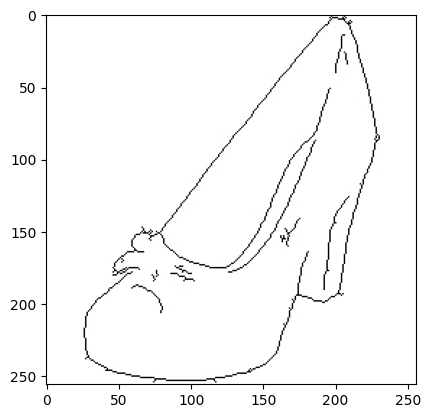

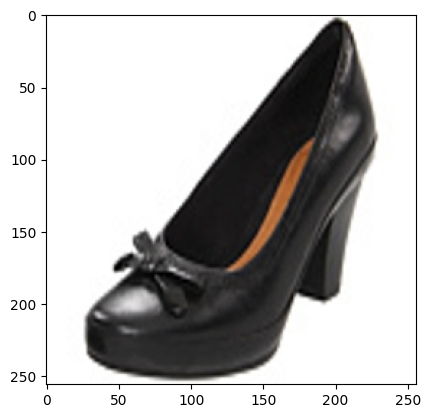

In [9]:
# display an image from the dataset
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# display the pair
show_image(train_dataset[0][0])
show_image(train_dataset[0][1])

# Model



## Model Arch
The referenced article mentions "In Pix2Pix, the generator is a convolutional network with U-net architecture." So, I am designing my generator similar to u-net.

For the discriminator:

The input will have four channels (height x width x 4). And I will try to use the patchGAN. "In Pix2Pix, the authors employ a different type of discriminator network (patchGAN type). The patchGAN network takes the concatenated input images and produces an output of size NxN."

### Generator

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    # enc
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # 128 x 128
    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1) # 64 x 64
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 32 x 32
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1) # 16 x 16
    self.conv5 = nn.Conv2d(512, 512, 4, 2, 1) # 8 x 8
    self.conv6 = nn.Conv2d(512, 512, 4, 2, 1) # 4 x 4
    self.conv7 = nn.Conv2d(512, 512, 4, 2, 1) # 2 x 2
    self.conv8 = nn.Conv2d(512, 512, 3, 2, 1) # 2 x 2
    # dec
    self.dec1 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
    self.dec2 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
    self.dec3 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
    self.dec4 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
    self.dec5 = nn.ConvTranspose2d(512 * 2, 256, 4, stride=2, padding=1)
    self.dec6 = nn.ConvTranspose2d(256 * 2, 128, 4, stride=2, padding=1)
    self.dec7 = nn.ConvTranspose2d(128 * 2, 64, 4, stride=2, padding=1)
    self.dec8 = nn.ConvTranspose2d(64 * 2, 3, 4, stride=2, padding=1)
    # activation
    self.relu = nn.LeakyReLU()
    self.tanh = nn.Tanh()

    # Batch norms
    self.bn64 = nn.BatchNorm2d(64)
    self.bn128 = nn.BatchNorm2d(128)
    self.bn256 = nn.BatchNorm2d(256)
    self.bn512 = nn.BatchNorm2d(512)


    # Dropout
    self.dropout = nn.Dropout(0.5)

  # forward
  def forward(self, x):
    # enc
    enc1 = self.relu(self.bn64(self.conv1(x)))
    enc2 = self.relu(self.bn128(self.conv2(enc1)))
    enc3 = self.relu(self.bn256(self.conv3(enc2)))
    enc4 = self.dropout(self.relu(self.bn512(self.conv4(enc3))))
    enc5 = self.dropout(self.relu(self.bn512(self.conv5(enc4))))
    enc6 = self.dropout(self.relu(self.bn512(self.conv6(enc5))))
    enc7 = self.dropout(self.relu(self.bn512(self.conv7(enc6))))
    enc8 = self.relu(self.bn512(self.conv8(enc7)))
    # dec
    x = self.dropout(self.relu(self.bn512(self.dec1(enc8))))
    x = torch.cat([x, enc7], dim=1)
    x = self.dropout(self.relu(self.bn512(self.dec2(x))))
    x = torch.cat([x, enc6], dim=1)
    x = self.dropout(self.relu(self.bn512(self.dec3(x))))
    x = torch.cat([x, enc5], dim=1)
    x = self.dropout(self.relu(self.bn512(self.dec4(x))))
    x = torch.cat([x, enc4], dim=1)
    x = self.relu(self.bn256(self.dec5(x)))
    x = torch.cat([x, enc3], dim=1)
    x = self.relu(self.bn128(self.dec6(x)))
    x = torch.cat([x, enc2], dim=1)
    x = self.relu(self.bn64(self.dec7(x)))
    x = torch.cat([x, enc1], dim=1)
    x = self.tanh(self.dec8(x))
    return x


In [ ]:
summary(Generator(), (32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 256, 256]         --
├─Conv2d: 1-1                            [32, 64, 128, 128]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─LeakyReLU: 1-3                         [32, 64, 128, 128]        --
├─Conv2d: 1-4                            [32, 128, 64, 64]         131,200
├─BatchNorm2d: 1-5                       [32, 128, 64, 64]         256
├─LeakyReLU: 1-6                         [32, 128, 64, 64]         --
├─Conv2d: 1-7                            [32, 256, 32, 32]         524,544
├─BatchNorm2d: 1-8                       [32, 256, 32, 32]         512
├─LeakyReLU: 1-9                         [32, 256, 32, 32]         --
├─Conv2d: 1-10                           [32, 512, 16, 16]         2,097,664
├─BatchNorm2d: 1-11                      [32, 512, 16, 16]         1,024
├─LeakyReLU: 1-12                        [32, 512, 16, 16] 

### Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_channels = 6):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(input_channels, 8, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 16, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, 4, 2, 1),
        )
    def forward(self, x):
        return self.discriminator(x)

In [ ]:
summary(Discriminator(), (32, 6, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1, 32, 32]           --
├─Sequential: 1-1                        [32, 1, 32, 32]           --
│    └─Conv2d: 2-1                       [32, 8, 256, 256]         440
│    └─LeakyReLU: 2-2                    [32, 8, 256, 256]         --
│    └─Conv2d: 2-3                       [32, 16, 128, 128]        2,064
│    └─LeakyReLU: 2-4                    [32, 16, 128, 128]        --
│    └─BatchNorm2d: 2-5                  [32, 16, 128, 128]        32
│    └─Conv2d: 2-6                       [32, 32, 128, 128]        4,640
│    └─BatchNorm2d: 2-7                  [32, 32, 128, 128]        64
│    └─LeakyReLU: 2-8                    [32, 32, 128, 128]        --
│    └─Conv2d: 2-9                       [32, 64, 128, 128]        18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 128, 128]        128
│    └─LeakyReLU: 2-11                   [32, 64, 128, 128]        --
│  

### Sanity check

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sketches, real_images = next(iter(train_loader))
sketches, real_images = sketches.to(device), real_images.to(device)

# check genrator
generator = Generator().to(device)
output = generator(sketches)
print(f"generator output shape is {output.shape} which is as expected? { output.shape == torch.Size([64, 3, 256, 256])}")

# check discriminator
discriminator = Discriminator().to(device)
discriminator_input = torch.cat([sketches, output], dim=1)

output = discriminator(torch.cat([sketches, output], dim=1))
print(f"discriminator output shape is {output.shape} which is as expected? { output.shape == torch.Size([64, 1, 32, 32])}")

generator output shape is torch.Size([64, 3, 256, 256]) which is as expected? True
discriminator output shape is torch.Size([64, 1, 32, 32]) which is as expected? True


## Training loop
For the discriminator I am using the total loss in the figure. For the generator, the loss is almost the same as generated loss (on the left side) except that it is the sigmoid cross-entropy of the NxN discriminator output and a matrix of ones. When this loss is back-propagated, the discriminator network’s parameters are frozen. And only the generator’s weights are adjusted.



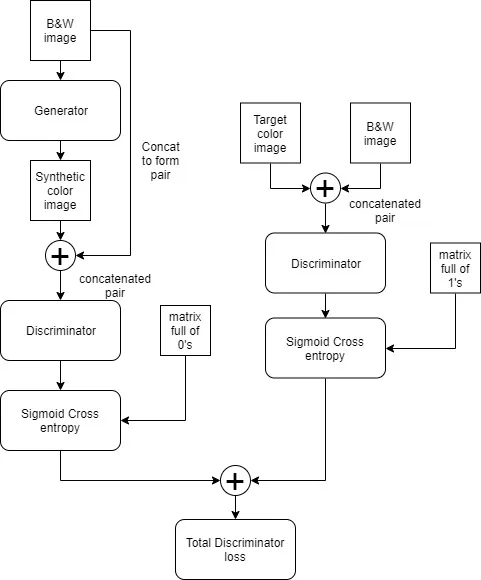

In [ ]:
# # helper function
# def sample_img(G, data_loader, PATH="test.jpg"):
#   pass
#   # G.eval()
#   # real_img_batch, cond_img_batch = next(iter(data_loader))
#   # real_img_batch, cond_img_batch = real_img_batch.to(device), cond_img_batch.to(device)
#   # fake_img_batch = G(cond_img_batch)
#   # img_batch = torch.cat((real_img_batch, cond_img_batch, fake_img_batch), 3)
#   # show_img(img_batch[0])
#   # plt.savefig(PATH)
#   # plt.show()
#   # # G.train()

In [ ]:
# hyper paramterts
num_epochs = 25
G_lr = 2e-3
D_lr = 2e-4
beta1 = 0.5
beta2 = 0.999
# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=G_lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=D_lr, betas=(beta1, beta2))

# schedulars
scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=10, eta_min=0)
scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=10, eta_min=0)


# Loss function
criterion = nn.BCEWithLogitsLoss() # adverserial loss
l1_loss = nn.L1Loss()

In [ ]:
%%time
from torchvision.utils import save_image
def train():
  for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for i, (sketches, real_images) in tqdm(enumerate(train_loader)):

      sketches = sketches.to(device)
      real_images = real_images.to(device)

      batch_size = sketches.size(0)

      real_labels = torch.ones(batch_size, 1, 32, 32, requires_grad=False, device=device)
      fake_labels = torch.zeros(batch_size, 1, 32, 32, requires_grad=False, device=device)

      ##### Train Generator #####

      synthetic_images = generator(sketches)
      fake_pair = torch.cat([sketches, synthetic_images], dim=1)

      # Discriminator output for fake pairs
      fake_output = discriminator(fake_pair)

      loss_G = criterion(fake_output, real_labels)
      l1_G = l1_loss(synthetic_images, real_images)
      loss_G = loss_G + 10 * l1_G

      optimizer_G.zero_grad()
      loss_G.backward()
      optimizer_G.step()

      ##### Train Discrimnator #####

      # Real pair
      real_pair = torch.cat([sketches, real_images], dim=1)
      real_output = discriminator(real_pair)
      loss_real = criterion(real_output, real_labels)

      # Fake pair (detach to avoid training generator)
      fake_pair = torch.cat([sketches, synthetic_images.detach()], dim=1)
      fake_output = discriminator(fake_pair)
      loss_fake = criterion(fake_output, fake_labels)

      loss_D = loss_real + loss_fake

      optimizer_D.zero_grad()
      loss_D.backward()
      optimizer_D.step()

      # Since training takes so much time, I will print the losses after every 100th epoch/
      if i % 100 == 0:
          print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")
      scheduler_G.step()
      scheduler_D.step()

      # Save generated images after each epoch
      save_image(synthetic_images.data[:25], f"/content/drive/MyDrive/generated_images/hw3/generated_images_epoch_{epoch+1}.png", nrow=5, normalize=True)
      # Save models
      torch.save(generator.state_dict(), f"/content/drive/MyDrive/models_for_hw3/generator_epoch_{epoch+1}.pth")
      torch.save(discriminator.state_dict(), f"/content/drive/MyDrive/models_for_hw3/discriminator_epoch_{epoch+1}.pth")

train()

0it [00:00, ?it/s]

[Epoch 0/25] [Batch 0/313] [D loss: 1.4394] [G loss: 9.7120]


100it [04:28,  2.82s/it]

[Epoch 0/25] [Batch 100/313] [D loss: 1.3773] [G loss: 2.7412]


200it [08:53,  2.60s/it]

[Epoch 0/25] [Batch 200/313] [D loss: 1.3852] [G loss: 2.5809]


300it [13:12,  2.56s/it]

[Epoch 0/25] [Batch 300/313] [D loss: 1.3524] [G loss: 2.4630]


313it [13:44,  2.63s/it]
0it [00:00, ?it/s]

[Epoch 1/25] [Batch 0/313] [D loss: 1.2783] [G loss: 2.2233]


100it [04:20,  2.70s/it]

[Epoch 1/25] [Batch 100/313] [D loss: 1.3217] [G loss: 2.4563]


200it [08:34,  2.55s/it]

[Epoch 1/25] [Batch 200/313] [D loss: 1.2249] [G loss: 2.3221]


300it [12:51,  2.52s/it]

[Epoch 1/25] [Batch 300/313] [D loss: 1.3012] [G loss: 2.2686]


313it [13:24,  2.57s/it]
0it [00:00, ?it/s]

[Epoch 2/25] [Batch 0/313] [D loss: 1.2540] [G loss: 2.3946]


100it [04:18,  2.55s/it]

[Epoch 2/25] [Batch 100/313] [D loss: 1.4231] [G loss: 2.0624]


200it [08:31,  2.60s/it]

[Epoch 2/25] [Batch 200/313] [D loss: 1.3650] [G loss: 2.2777]


300it [12:49,  2.56s/it]

[Epoch 2/25] [Batch 300/313] [D loss: 1.3265] [G loss: 1.9346]


313it [13:21,  2.56s/it]
0it [00:00, ?it/s]

[Epoch 3/25] [Batch 0/313] [D loss: 1.4399] [G loss: 2.5584]


100it [04:20,  2.65s/it]

[Epoch 3/25] [Batch 100/313] [D loss: 1.4174] [G loss: 2.2887]


200it [08:37,  2.55s/it]

[Epoch 3/25] [Batch 200/313] [D loss: 1.3321] [G loss: 2.1379]


300it [12:59,  2.67s/it]

[Epoch 3/25] [Batch 300/313] [D loss: 1.3912] [G loss: 2.2505]


313it [13:31,  2.59s/it]
0it [00:00, ?it/s]

[Epoch 4/25] [Batch 0/313] [D loss: 1.2975] [G loss: 2.2591]


100it [04:19,  2.55s/it]

[Epoch 4/25] [Batch 100/313] [D loss: 1.3939] [G loss: 2.1796]


200it [08:34,  2.55s/it]

[Epoch 4/25] [Batch 200/313] [D loss: 1.2857] [G loss: 1.9011]


300it [12:51,  2.70s/it]

[Epoch 4/25] [Batch 300/313] [D loss: 1.3573] [G loss: 2.1162]


313it [13:23,  2.57s/it]
0it [00:00, ?it/s]

[Epoch 5/25] [Batch 0/313] [D loss: 1.3967] [G loss: 2.0475]


100it [04:18,  2.54s/it]

[Epoch 5/25] [Batch 100/313] [D loss: 1.4089] [G loss: 2.0962]


200it [08:38,  2.54s/it]

[Epoch 5/25] [Batch 200/313] [D loss: 1.3601] [G loss: 1.9206]


300it [12:57,  2.58s/it]

[Epoch 5/25] [Batch 300/313] [D loss: 1.4419] [G loss: 2.2174]


313it [13:30,  2.59s/it]
0it [00:00, ?it/s]

[Epoch 6/25] [Batch 0/313] [D loss: 1.4269] [G loss: 2.0421]


100it [04:14,  2.43s/it]

[Epoch 6/25] [Batch 100/313] [D loss: 1.3774] [G loss: 2.0954]


200it [08:30,  2.55s/it]

[Epoch 6/25] [Batch 200/313] [D loss: 1.4293] [G loss: 2.1321]


300it [12:48,  2.60s/it]

[Epoch 6/25] [Batch 300/313] [D loss: 1.3532] [G loss: 2.0427]


313it [13:20,  2.56s/it]
0it [00:00, ?it/s]

[Epoch 7/25] [Batch 0/313] [D loss: 1.4315] [G loss: 1.9345]


100it [04:18,  2.55s/it]

[Epoch 7/25] [Batch 100/313] [D loss: 1.3213] [G loss: 1.9968]


200it [08:36,  2.48s/it]

[Epoch 7/25] [Batch 200/313] [D loss: 1.3400] [G loss: 1.9892]


300it [12:59,  2.82s/it]

[Epoch 7/25] [Batch 300/313] [D loss: 1.3557] [G loss: 1.9489]


313it [13:32,  2.60s/it]
0it [00:00, ?it/s]

[Epoch 8/25] [Batch 0/313] [D loss: 1.3812] [G loss: 2.0794]


100it [04:21,  2.60s/it]

[Epoch 8/25] [Batch 100/313] [D loss: 1.4538] [G loss: 1.9605]


200it [08:39,  2.56s/it]

[Epoch 8/25] [Batch 200/313] [D loss: 1.3232] [G loss: 2.1170]


300it [12:58,  2.54s/it]

[Epoch 8/25] [Batch 300/313] [D loss: 1.3251] [G loss: 2.2212]


313it [13:32,  2.60s/it]
0it [00:00, ?it/s]

[Epoch 9/25] [Batch 0/313] [D loss: 1.3462] [G loss: 1.8687]


100it [04:23,  2.73s/it]

[Epoch 9/25] [Batch 100/313] [D loss: 1.3586] [G loss: 1.8604]


200it [08:45,  2.54s/it]

[Epoch 9/25] [Batch 200/313] [D loss: 1.3636] [G loss: 1.9821]


300it [13:08,  2.87s/it]

[Epoch 9/25] [Batch 300/313] [D loss: 1.3680] [G loss: 1.8516]


313it [13:41,  2.62s/it]
0it [00:00, ?it/s]

[Epoch 10/25] [Batch 0/313] [D loss: 1.3909] [G loss: 1.8217]


100it [04:20,  2.59s/it]

[Epoch 10/25] [Batch 100/313] [D loss: 1.3064] [G loss: 1.8800]


200it [08:38,  2.75s/it]

[Epoch 10/25] [Batch 200/313] [D loss: 1.3925] [G loss: 1.8618]


300it [12:58,  2.51s/it]

[Epoch 10/25] [Batch 300/313] [D loss: 1.3536] [G loss: 1.7306]


313it [13:31,  2.59s/it]
0it [00:00, ?it/s]

[Epoch 11/25] [Batch 0/313] [D loss: 1.3345] [G loss: 1.8464]


100it [04:21,  2.55s/it]

[Epoch 11/25] [Batch 100/313] [D loss: 1.3705] [G loss: 1.9378]


200it [08:36,  2.47s/it]

[Epoch 11/25] [Batch 200/313] [D loss: 1.3697] [G loss: 1.9957]


300it [12:55,  2.55s/it]

[Epoch 11/25] [Batch 300/313] [D loss: 1.4006] [G loss: 1.9785]


313it [13:29,  2.59s/it]
0it [00:00, ?it/s]

[Epoch 12/25] [Batch 0/313] [D loss: 1.3628] [G loss: 1.7426]


100it [04:22,  2.55s/it]

[Epoch 12/25] [Batch 100/313] [D loss: 1.3964] [G loss: 1.8607]


200it [08:43,  2.59s/it]

[Epoch 12/25] [Batch 200/313] [D loss: 1.4019] [G loss: 1.8381]


300it [13:05,  2.77s/it]

[Epoch 12/25] [Batch 300/313] [D loss: 1.4188] [G loss: 1.7236]


313it [13:38,  2.62s/it]
0it [00:00, ?it/s]

[Epoch 13/25] [Batch 0/313] [D loss: 1.3597] [G loss: 1.7141]


100it [04:20,  2.56s/it]

[Epoch 13/25] [Batch 100/313] [D loss: 1.3723] [G loss: 1.7637]


200it [08:39,  2.50s/it]

[Epoch 13/25] [Batch 200/313] [D loss: 1.3885] [G loss: 1.7315]


300it [12:58,  2.53s/it]

[Epoch 13/25] [Batch 300/313] [D loss: 1.3791] [G loss: 1.7950]


313it [13:31,  2.59s/it]
0it [00:00, ?it/s]

[Epoch 14/25] [Batch 0/313] [D loss: 1.3594] [G loss: 1.8571]


100it [04:21,  2.67s/it]

[Epoch 14/25] [Batch 100/313] [D loss: 1.3815] [G loss: 1.8513]


200it [08:43,  2.77s/it]

[Epoch 14/25] [Batch 200/313] [D loss: 1.4106] [G loss: 1.8525]


300it [13:04,  2.80s/it]

[Epoch 14/25] [Batch 300/313] [D loss: 1.3486] [G loss: 1.8898]


313it [13:36,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 15/25] [Batch 0/313] [D loss: 1.3954] [G loss: 1.7999]


100it [04:18,  2.58s/it]

[Epoch 15/25] [Batch 100/313] [D loss: 1.4379] [G loss: 1.8052]


200it [08:39,  2.84s/it]

[Epoch 15/25] [Batch 200/313] [D loss: 1.3871] [G loss: 1.6856]


300it [13:03,  2.64s/it]

[Epoch 15/25] [Batch 300/313] [D loss: 1.3617] [G loss: 1.8379]


313it [13:36,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 16/25] [Batch 0/313] [D loss: 1.3583] [G loss: 1.7653]


100it [04:22,  2.71s/it]

[Epoch 16/25] [Batch 100/313] [D loss: 1.3535] [G loss: 1.6022]


200it [08:44,  2.53s/it]

[Epoch 16/25] [Batch 200/313] [D loss: 1.3178] [G loss: 1.6109]


300it [13:05,  2.59s/it]

[Epoch 16/25] [Batch 300/313] [D loss: 1.3553] [G loss: 1.6832]


313it [13:37,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 17/25] [Batch 0/313] [D loss: 1.3977] [G loss: 1.8260]


100it [04:20,  2.54s/it]

[Epoch 17/25] [Batch 100/313] [D loss: 1.3731] [G loss: 1.6558]


200it [08:40,  2.82s/it]

[Epoch 17/25] [Batch 200/313] [D loss: 1.4040] [G loss: 1.7801]


300it [13:04,  2.73s/it]

[Epoch 17/25] [Batch 300/313] [D loss: 1.4123] [G loss: 1.6549]


313it [13:37,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 18/25] [Batch 0/313] [D loss: 1.3388] [G loss: 1.7922]


100it [04:20,  2.54s/it]

[Epoch 18/25] [Batch 100/313] [D loss: 1.4116] [G loss: 1.6673]


200it [08:40,  2.56s/it]

[Epoch 18/25] [Batch 200/313] [D loss: 1.3463] [G loss: 1.7244]


300it [13:00,  2.57s/it]

[Epoch 18/25] [Batch 300/313] [D loss: 1.3844] [G loss: 1.7409]


313it [13:34,  2.60s/it]
0it [00:00, ?it/s]

[Epoch 19/25] [Batch 0/313] [D loss: 1.3869] [G loss: 1.7296]


100it [04:21,  2.53s/it]

[Epoch 19/25] [Batch 100/313] [D loss: 1.3838] [G loss: 1.6553]


200it [08:43,  2.63s/it]

[Epoch 19/25] [Batch 200/313] [D loss: 1.4091] [G loss: 1.6582]


300it [13:04,  2.50s/it]

[Epoch 19/25] [Batch 300/313] [D loss: 1.3954] [G loss: 1.7306]


313it [13:37,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 20/25] [Batch 0/313] [D loss: 1.3932] [G loss: 1.7152]


100it [04:22,  2.64s/it]

[Epoch 20/25] [Batch 100/313] [D loss: 1.3538] [G loss: 1.6211]


200it [08:42,  2.58s/it]

[Epoch 20/25] [Batch 200/313] [D loss: 1.4064] [G loss: 1.6706]


300it [13:03,  2.62s/it]

[Epoch 20/25] [Batch 300/313] [D loss: 1.3459] [G loss: 1.7213]


313it [13:37,  2.61s/it]
0it [00:00, ?it/s]

[Epoch 21/25] [Batch 0/313] [D loss: 1.3881] [G loss: 1.8104]


100it [04:21,  2.60s/it]

[Epoch 21/25] [Batch 100/313] [D loss: 1.3408] [G loss: 1.7420]


200it [08:42,  2.62s/it]

[Epoch 21/25] [Batch 200/313] [D loss: 1.3604] [G loss: 1.6558]


300it [13:06,  2.68s/it]

[Epoch 21/25] [Batch 300/313] [D loss: 1.3684] [G loss: 1.6805]


313it [13:39,  2.62s/it]
0it [00:00, ?it/s]

[Epoch 22/25] [Batch 0/313] [D loss: 1.3657] [G loss: 1.6746]


100it [04:22,  2.54s/it]

[Epoch 22/25] [Batch 100/313] [D loss: 1.3282] [G loss: 1.8536]


200it [08:46,  2.73s/it]

[Epoch 22/25] [Batch 200/313] [D loss: 1.3967] [G loss: 1.7005]


300it [13:07,  2.65s/it]

[Epoch 22/25] [Batch 300/313] [D loss: 1.3561] [G loss: 1.6874]


313it [13:41,  2.62s/it]
0it [00:00, ?it/s]

[Epoch 23/25] [Batch 0/313] [D loss: 1.4288] [G loss: 1.6185]


100it [04:17,  2.58s/it]

[Epoch 23/25] [Batch 100/313] [D loss: 1.3765] [G loss: 1.6496]


200it [08:35,  2.65s/it]

[Epoch 23/25] [Batch 200/313] [D loss: 1.3223] [G loss: 1.7038]


300it [12:55,  2.52s/it]

[Epoch 23/25] [Batch 300/313] [D loss: 1.4060] [G loss: 1.7365]


313it [13:28,  2.58s/it]
0it [00:00, ?it/s]

[Epoch 24/25] [Batch 0/313] [D loss: 1.3603] [G loss: 1.6193]


100it [04:21,  2.57s/it]

[Epoch 24/25] [Batch 100/313] [D loss: 1.4030] [G loss: 1.5865]


200it [08:42,  2.59s/it]

[Epoch 24/25] [Batch 200/313] [D loss: 1.3435] [G loss: 1.6420]


300it [13:08,  2.73s/it]

[Epoch 24/25] [Batch 300/313] [D loss: 1.3695] [G loss: 1.5900]


313it [13:42,  2.63s/it]

CPU times: user 5h 19min, sys: 30min 43s, total: 5h 49min 44s
Wall time: 5h 39min 4s


# Evaluation and examples

In [11]:
generator_best = Generator().to("cuda")
generator_best.load_state_dict(torch.load("/content/drive/MyDrive/models_for_hw3/generator_epoch_24.pth"))

best_output_path = "/content/drive/MyDrive/generated_images/hw3/generated_images_epoch_24.png"

## Showing best model (visually)

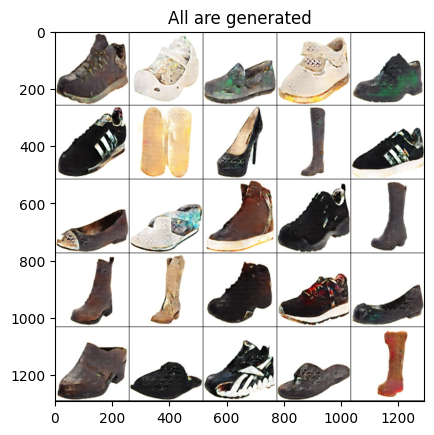

In [13]:
img = Image.open(best_output_path)
img = transforms.ToTensor()(img)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title("All are generated")
plt.show()

## Evaluation

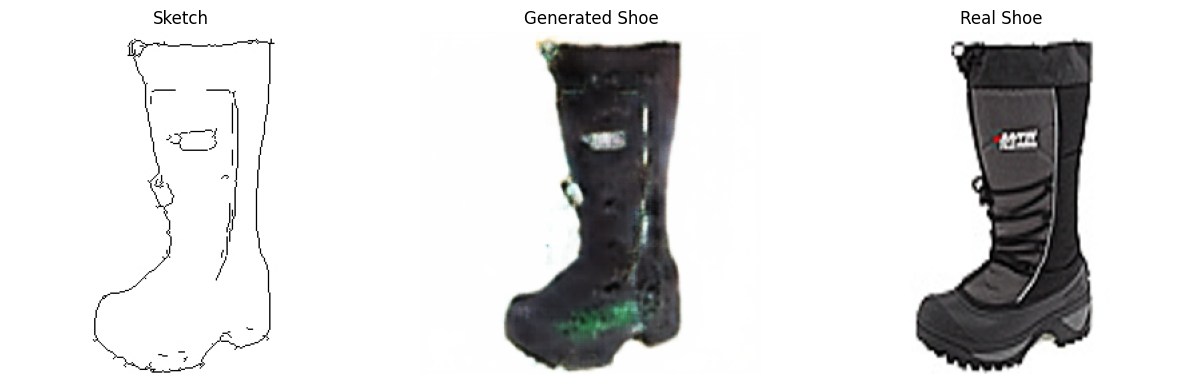

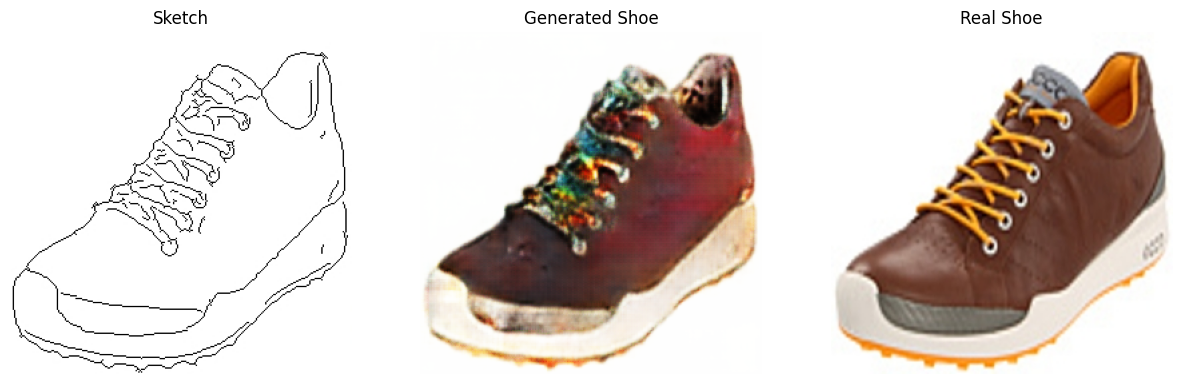

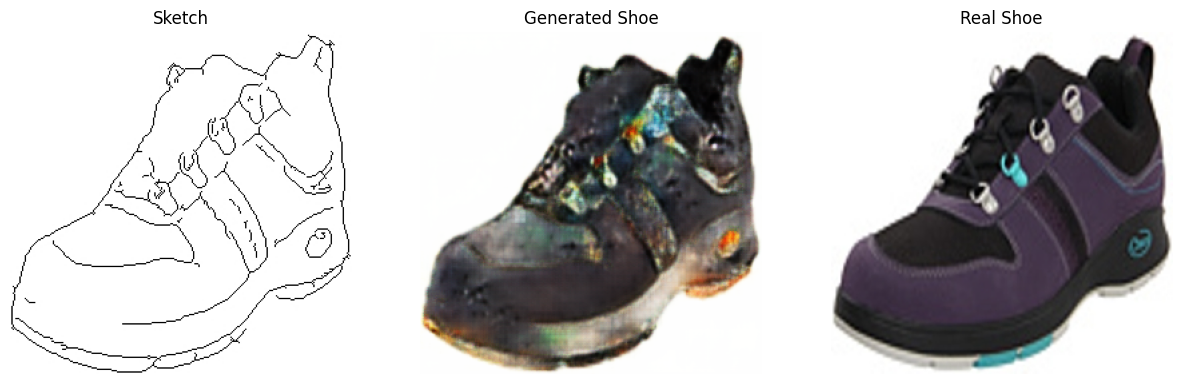

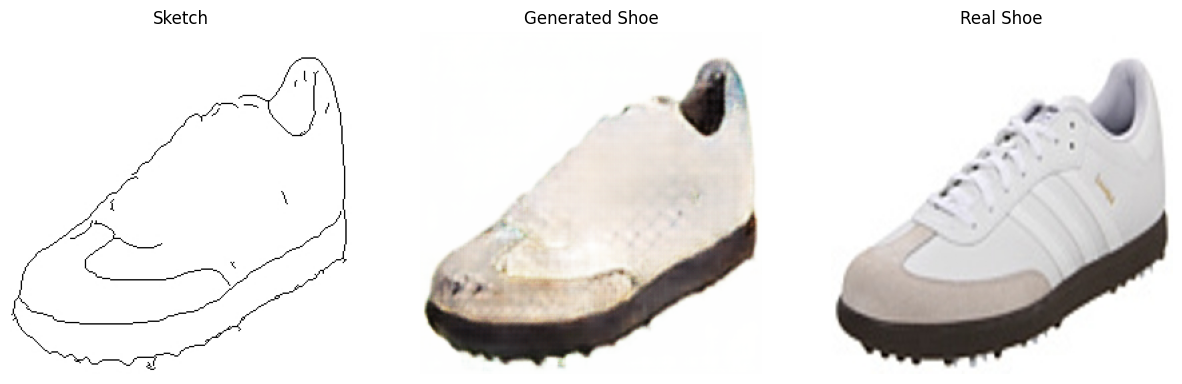

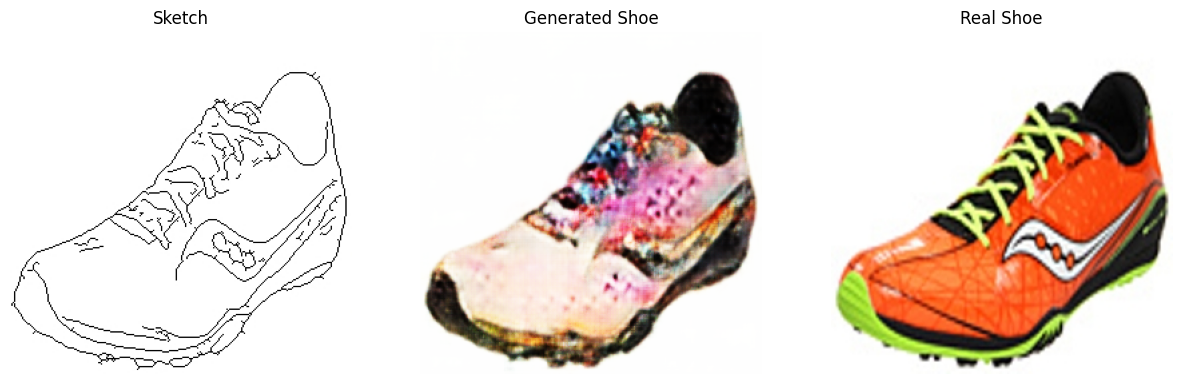

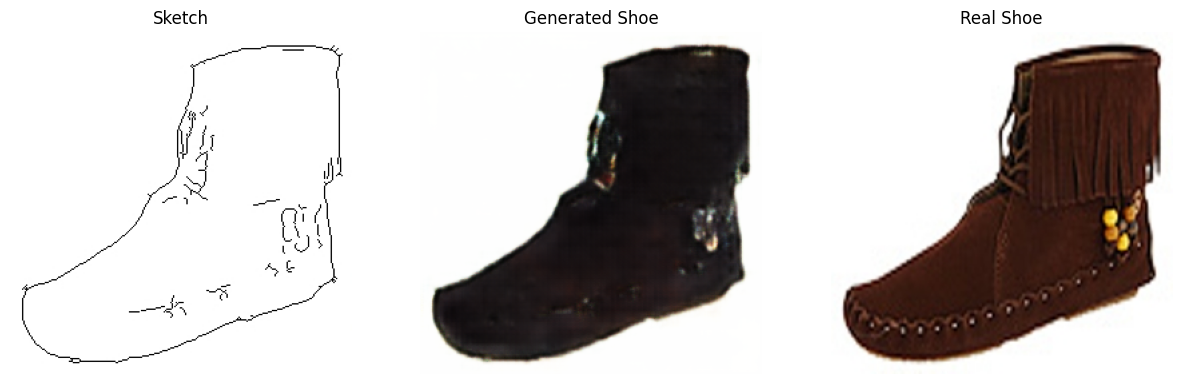

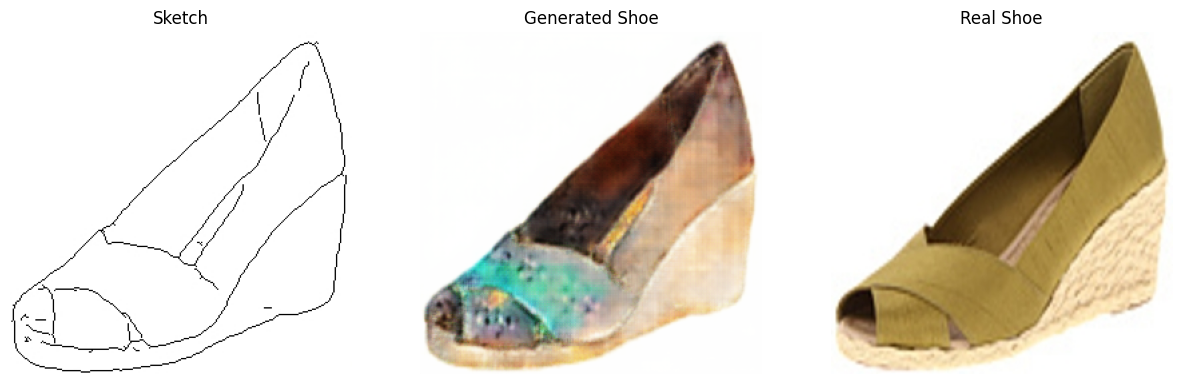

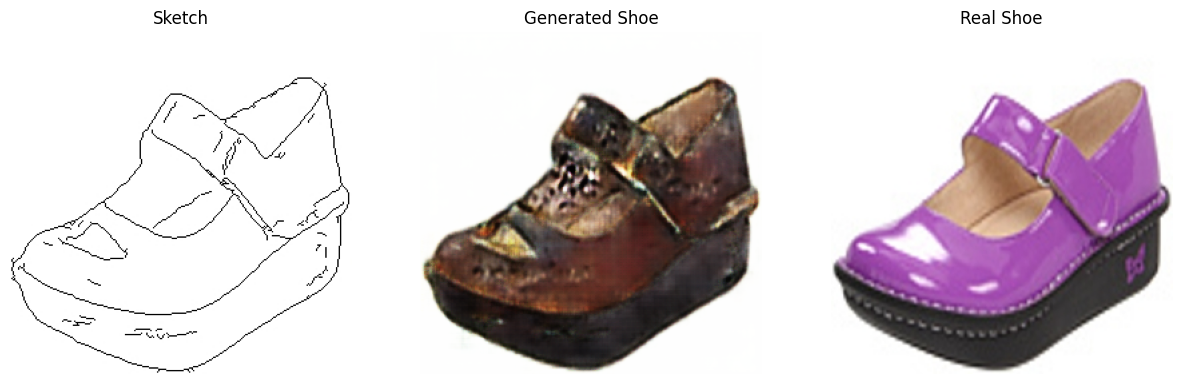

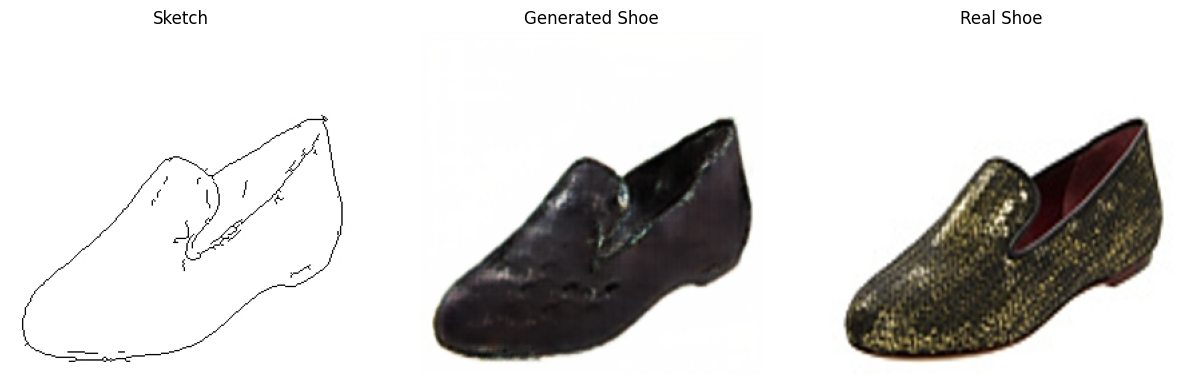

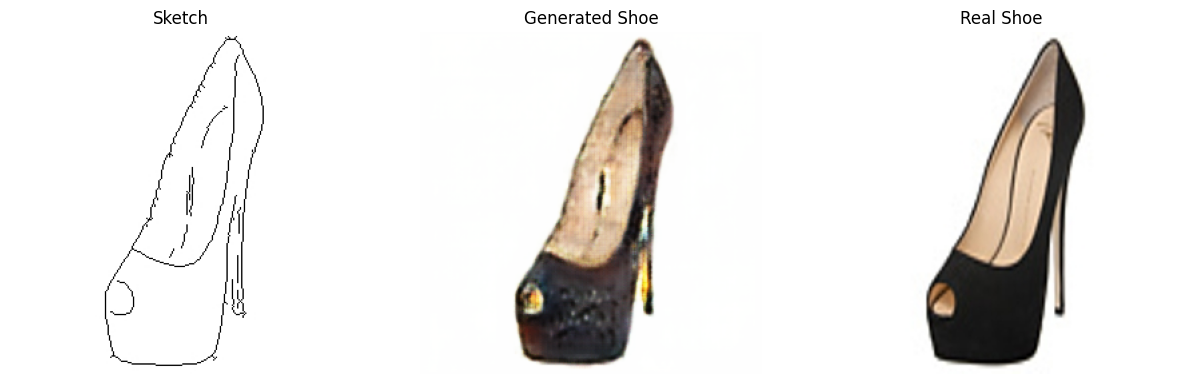

In [29]:
num_images = 10
images_shown = 0
device = "cuda"

with torch.no_grad():  # Disable gradient calculations for inference
    for i, (sketches, real_images) in enumerate(val_loader):
        if images_shown >= num_images:
            break

        # Move the data to the appropriate device
        sketches = sketches.to(device)
        real_images = real_images.to(device)


        # Generate the images from the sketches
        generated_images = generator_best(sketches)

        # Detach and move to CPU for visualization
        sketches = (sketches.cpu() + 1) / 2
        real_images = (real_images.cpu() + 1) / 2
        generated_images = (generated_images.cpu() + 1) / 2




        for j in range(min(sketches.size(0), num_images - images_shown)):
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(sketches[j].permute(1, 2, 0), cmap='gray')
            axs[0].set_title("Sketch")
            axs[0].axis('off')

            axs[1].imshow(generated_images[j].permute(1, 2, 0))
            axs[1].set_title("Generated Shoe")
            axs[1].axis('off')

            axs[2].imshow(real_images[j].permute(1, 2, 0))
            axs[2].set_title("Real Shoe")
            axs[2].axis('off')

            plt.show()
            images_shown += 1

        if images_shown >= num_images:
            break

## 3 real examples

In [31]:

# List of image paths
image_paths = ['sketch2.jpg', 'sketch3.jpg', 'Jacob_drawing.jpg']

# Transformation for all images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((256, 256)),  # Resize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Function to process a single image
def process_image(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert("L").convert("RGB")
    tensor_image = transform(grayscale_image)
    return tensor_image

# Process all images
tensor_images = [process_image(image_path) for image_path in image_paths]

# Now tensor_images contains the normalized black and white tensors for all three images
for i, tensor_image in enumerate(tensor_images):
    print(f"Image {i+1} shape: {tensor_image.shape}")

Image 1 shape: torch.Size([3, 256, 256])
Image 2 shape: torch.Size([3, 256, 256])
Image 3 shape: torch.Size([3, 256, 256])


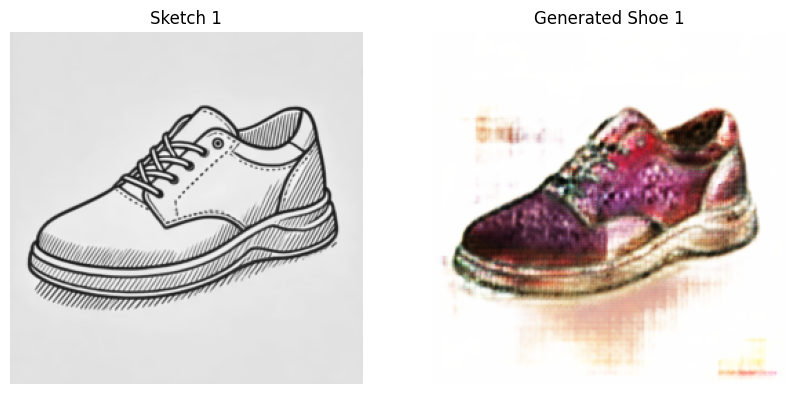

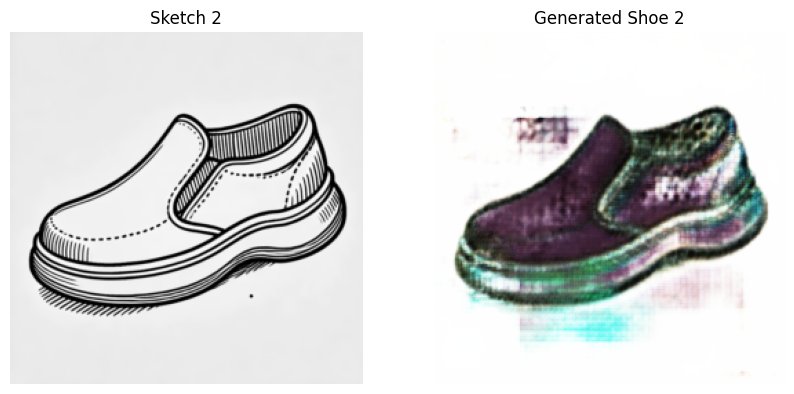

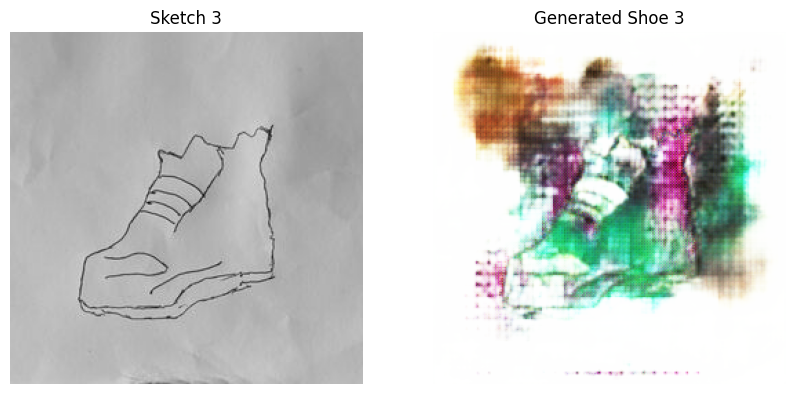

In [32]:
device = "cuda"
with torch.no_grad():
    for i, sketch in enumerate(tensor_images):
        sketch = sketch.to(device)

        batch_size = 4
        sketch_batch = sketch.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        generated_images = generator_best(sketch_batch)
        generated_image = generated_images[0]
        sketch = (sketch.cpu() + 1) / 2
        generated_image = (generated_image.cpu() + 1) / 2
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(sketch.permute(1, 2, 0), cmap='gray')
        axs[0].set_title(f"Sketch {i+1}")
        axs[0].axis('off')

        axs[1].imshow(generated_image.permute(1, 2, 0))
        axs[1].set_title(f"Generated Shoe {i+1}")
        axs[1].axis('off')

        plt.show()

# Discussion
I feel like I should've tried to make the sketches have 1 channel since all we need is 2 colors (black and white) for sketches and that would make the model archeticture simplar and maybe learn more than 3 channels. Also, I have used only 20000 samples due to limited resources. 

For the generator, I made a u-net like model with 8 conv layers for the encoder part and 8 deconv layers for the decoder part. For the discrimenator, I tried to make it simple but deep with 8 conv layers where channels go up to 64 then back to 1 and I used patchGAN. Overall, I followed the pix2pix paper and I calculated losses as they described. The model was able to generate some good results with only 25 epochs, I think the model would do better with more data and more training.

**Note: For the real exampls, only one was drawn by someone I know, if I have more time, I would ask more people to participate and draw more sketches :).
The model did horribly for that sketch, I think because the image has so many shadows and with no white background so the model couldn't understand the sketch becuase it is not clear like the training data.